In [16]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import json
import os
import numpy as np
import itertools
from collections import Counter

from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict

import notebook_utils as nbu

In [2]:
12 // 20000

0

In [18]:
tokenizer_dir = "../../../tokenizers"

languages = ('ar', 'zh', 'el', 'tr', 'es', 'en')
languages_old_order = ('ar', 'tr', 'zh','el', 'es', 'en')
multil_string = 'ar-tr-zh-el-es-en'

alphas = ('0.0', '0.25', '0.5')#, '0.75', '1.0')
# alphas_num = np.array([float(alpha) for alpha in alphas])
NV_mono = 20000
NV_multi = 120000
tok_type = "sp-unigram"

# load the statistics from monolingual corpora created using the multilingual tokenizer
token_stats_raw = {}
for alpha in alphas:
    token_stats_raw[alpha] = {}
    for lang in languages:
        tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-bpe", lang, f"alpha-{alpha}_N-20000", f"token_freq_{lang}_{alpha}.json")
        with open(tokenizer_stats_path) as f:
            token_stats_raw[alpha][lang] = json.load(f)

# load the all-training-data multilingual tokenizer statistics
overall_token_stats = {}
for alpha in alphas:
    overall_token_stats[alpha] = {}
    for lang_idx, lang in enumerate(languages):
        for tok, freq in token_stats_raw[alpha][lang].items():
            
            overall_token_stats[alpha][str(int(tok) + (NV_mono * lang_idx))] = freq
            
            
# update tokens_stast
token_stats = {}
for alpha in alphas:
    token_stats[alpha] = {}
    for lang2 in languages:
        token_stats[alpha][lang2] = {}
        for lang_idx, lang in enumerate(languages):
            for tok, freq in token_stats_raw[alpha][lang].items():
                if lang == lang2: 
                    token_stats[alpha][lang2][str(int(tok) + (NV_mono * lang_idx))] = freq
                else:
                    token_stats[alpha][lang2][str(int(tok) + (NV_mono * lang_idx))] = 0
            

In [19]:
# create the distributions for each alpha and language
def distribution_from_stats(stats, NV):
    dist = np.zeros(NV)
    assert len(stats) == NV
    for token, freq in stats.items():
        dist[int(token)] = freq
    dist /= dist.sum()
    return dist

token_dists = {}
overall_token_dists = {}
for alpha in alphas:
    token_dists[alpha] = {}
    for lang in languages:
        token_dists[alpha][lang] = distribution_from_stats(token_stats[alpha][lang], NV_multi)
    
    overall_token_dists[alpha] = distribution_from_stats(overall_token_stats[alpha], NV_multi)

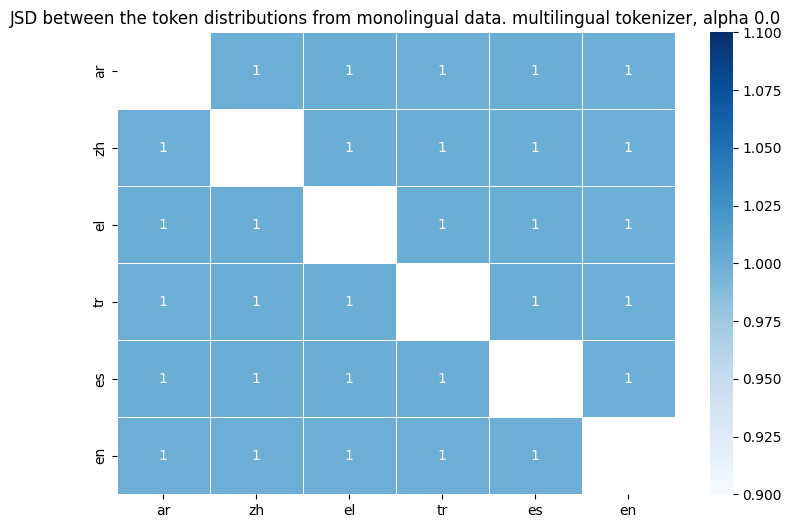

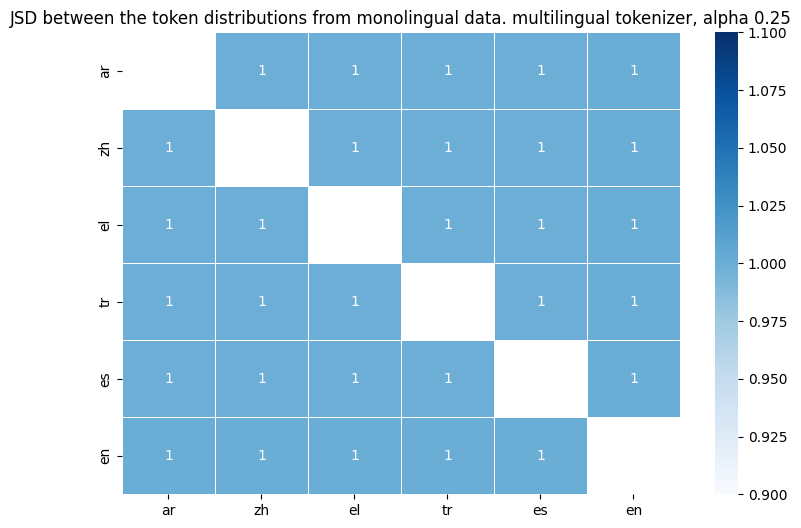

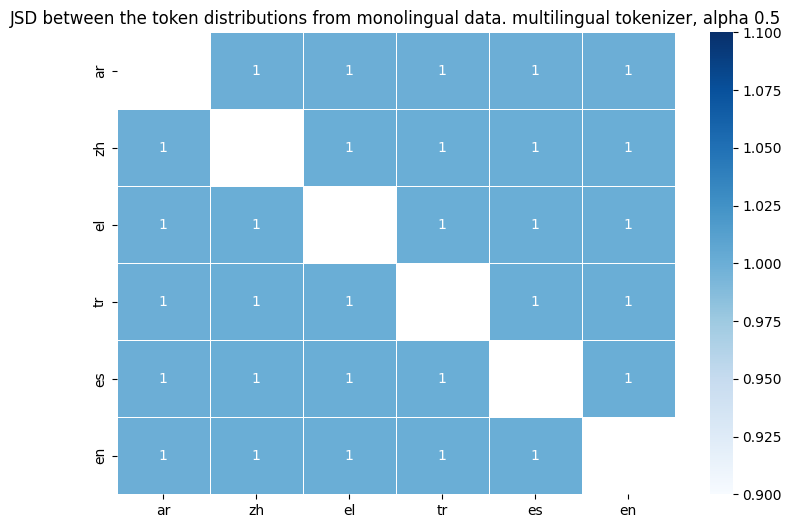

In [20]:
# compute the Jensen–Shannon divergence between the distributions
from scipy.spatial.distance import jensenshannon

jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1, lang2 in itertools.product(languages, languages):
        # to get the divergence, we need to square the JS-distances
        jds[alpha][(lang1, lang2)] = jensenshannon(token_dists[alpha][lang1], token_dists[alpha][lang2], base=2.) ** 2.

# plot the KL divergence as a heatmap
for alpha in alphas:
    # plt.figure(figsize=(10, 10))
    divergences = np.array([[jds[alpha][(lang1, lang2)] for lang1 in languages] for lang2 in languages])

    f, ax = plt.subplots(figsize=(9, 6))
    # mask = np.zeros_like(divergences, dtype=np.bool)
    mask = np.eye(divergences.shape[0], dtype='bool')
    sns.heatmap(divergences, mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues")

    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"JSD between the token distributions from monolingual data. multilingual tokenizer, alpha {alpha}")
    plt.show()

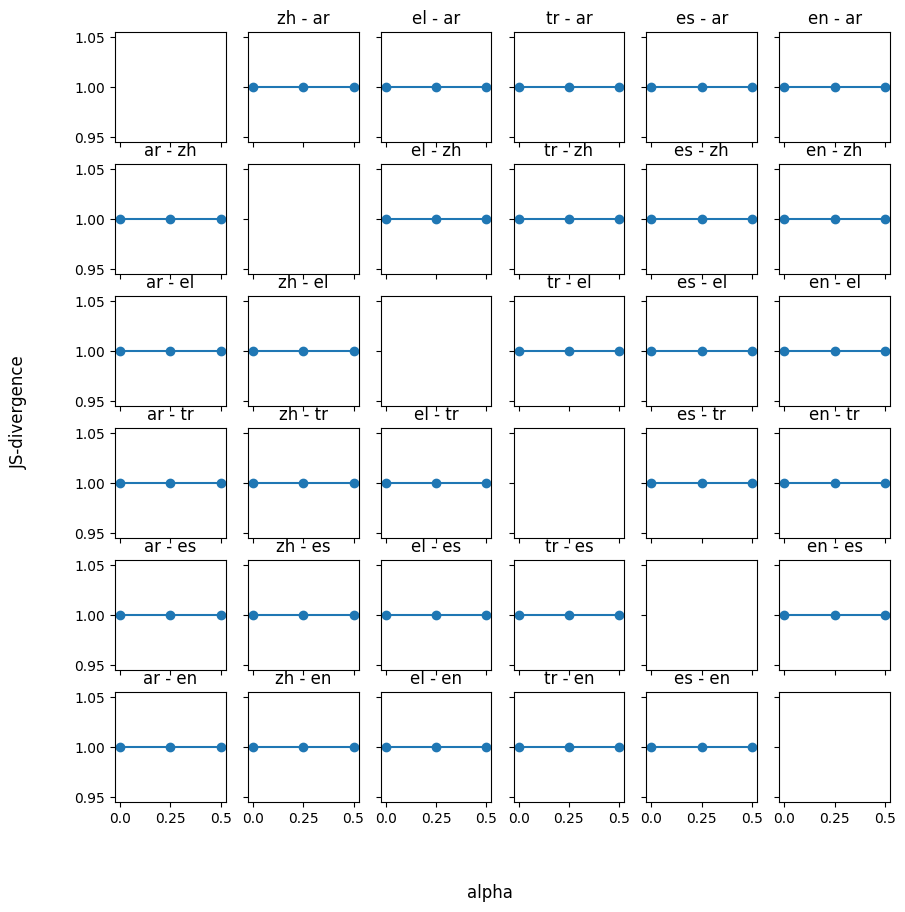

In [21]:
# plot the JS divergence as a grid of plots (one for each language pair) with x = alpha and y = divergence
fig, axes = plt.subplots(len(languages), len(languages), figsize=(10, 10), sharex=True, sharey=True)
for lang1, lang2 in itertools.product(languages, languages):
    if lang1 == lang2:
        continue
    ax = axes[languages.index(lang2), languages.index(lang1)]
    ax.plot(alphas, [jds[alpha][(lang1, lang2)] for alpha in alphas], marker='o')
    ax.set_title(f"{lang1} - {lang2}")
    # ax.set_xlabel("alpha")
    # ax.set_ylabel("JS-divergence")
fig.supxlabel("alpha")
fig.supylabel("JS-divergence")
plt.show()

- observation: the divergences never go higher with more data


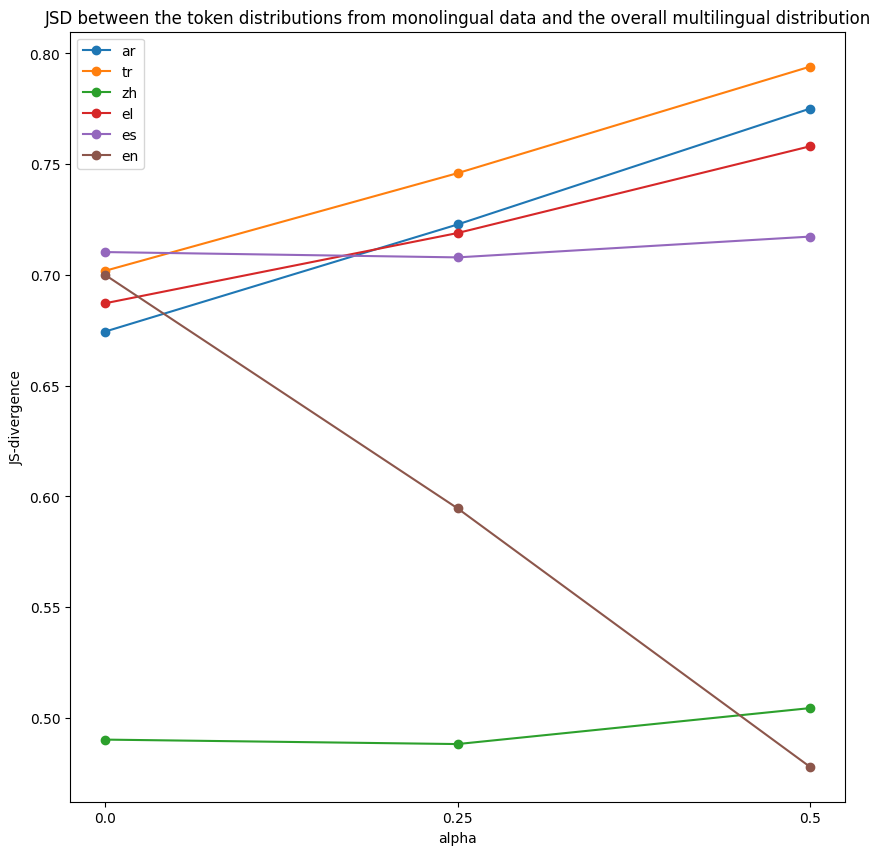

In [22]:
# compute the Jensen–Shannon divergence between the monolingual distributions and the overall distribution
jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1 in languages:
        jds[alpha][lang1] = jensenshannon(token_dists[alpha][lang1], overall_token_dists[alpha], base=2.) ** 2

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([jds[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([jds[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("JS-divergence")
plt.title("JSD between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

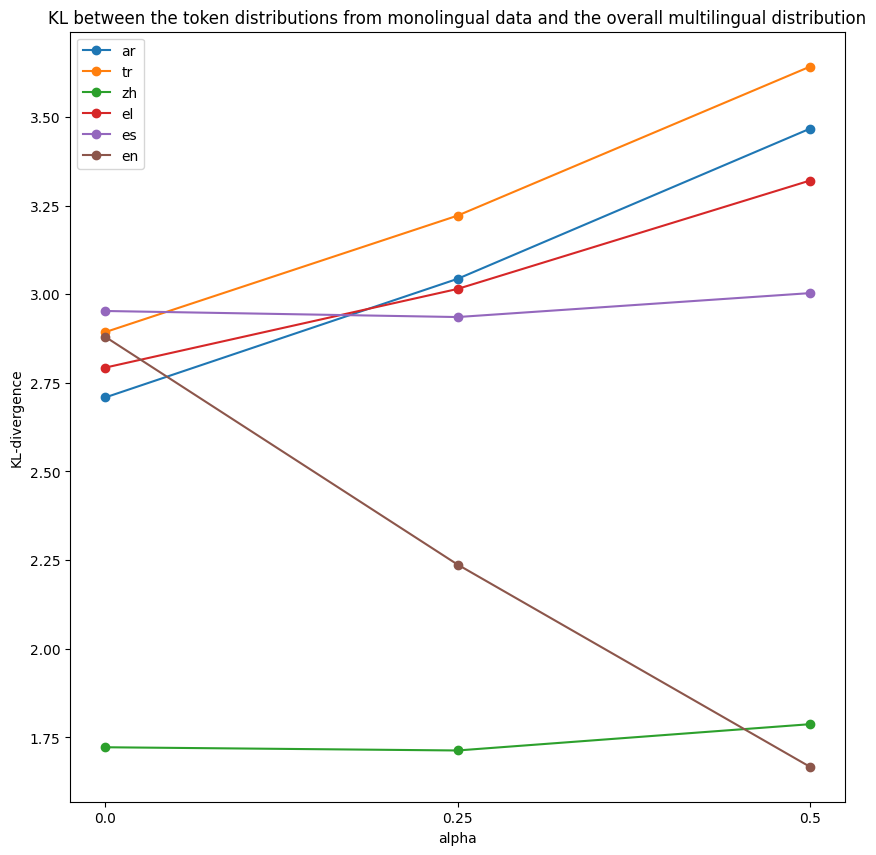

In [23]:
# compute the KL divergence between the monolingual distributions and the overall distribution
from scipy.stats import entropy

kls = {}
for alpha in alphas:
    kls[alpha] = {}
    for lang1 in languages:
        kls[alpha][lang1] = entropy(token_dists[alpha][lang1], overall_token_dists[alpha], base=2)

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([kls[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([kls[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("KL-divergence")
plt.title("KL between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

## Tokenizer profile plot PDFs

<Figure size 640x480 with 0 Axes>

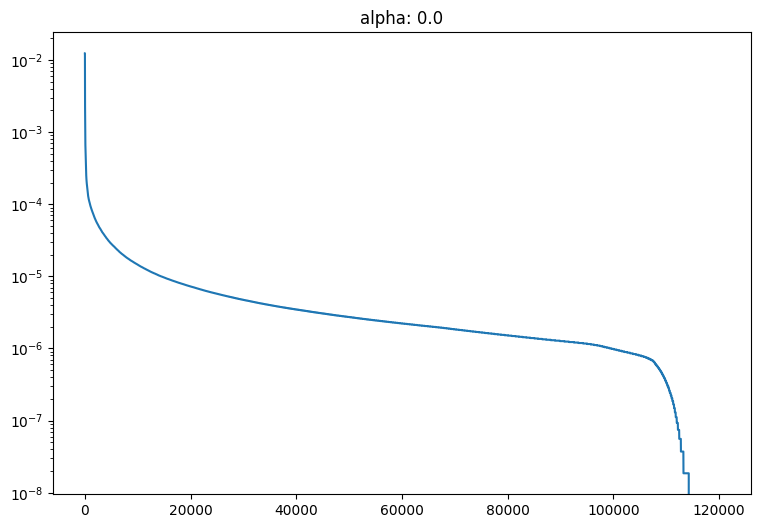

<Figure size 640x480 with 0 Axes>

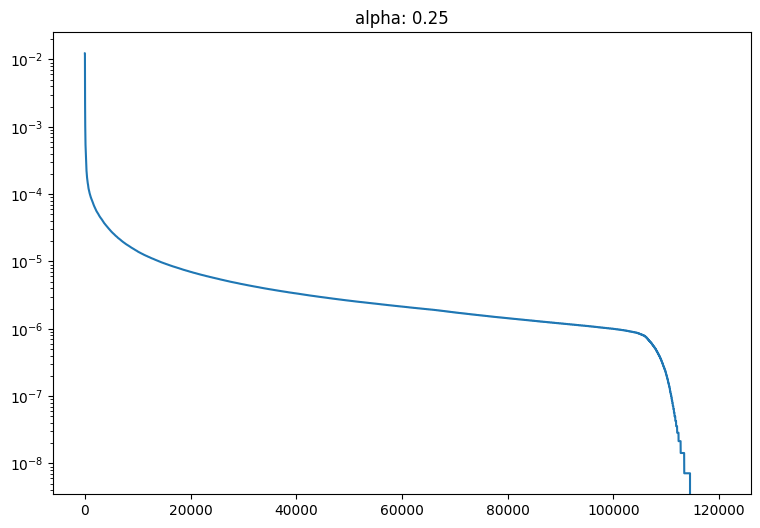

<Figure size 640x480 with 0 Axes>

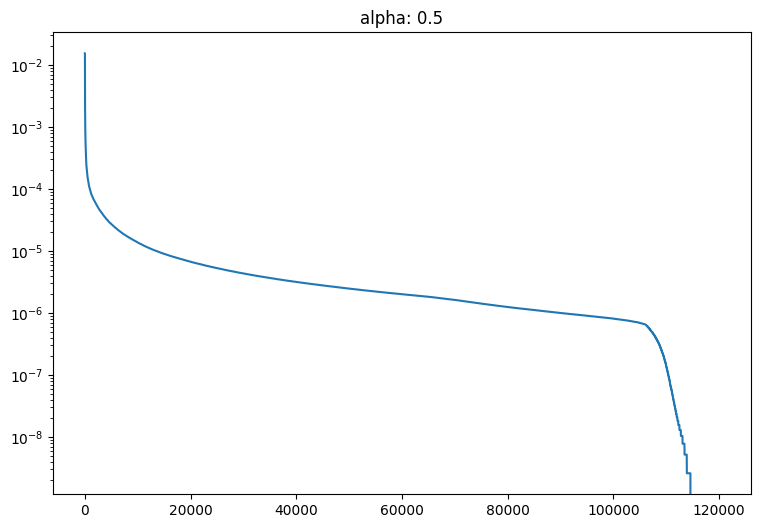

In [24]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    sorted_data = np.sort(overall_token_dists[alpha])[::-1]
    ax.plot(sorted_data)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    plt.show()


# For each language

<Figure size 640x480 with 0 Axes>

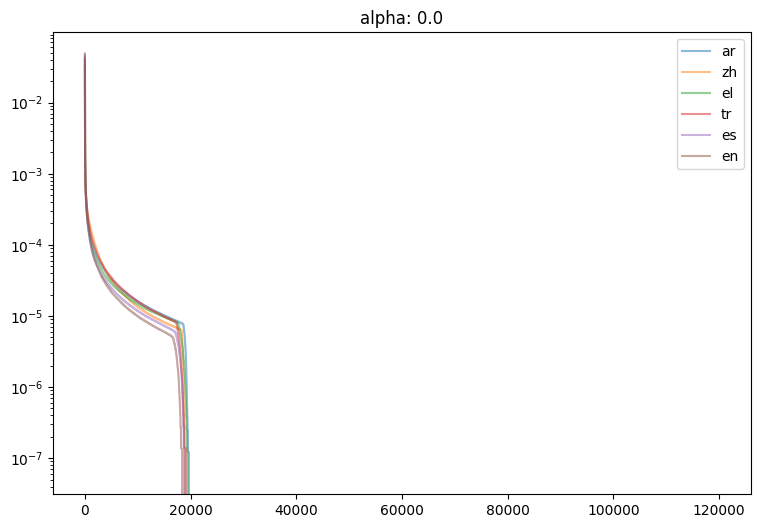

<Figure size 640x480 with 0 Axes>

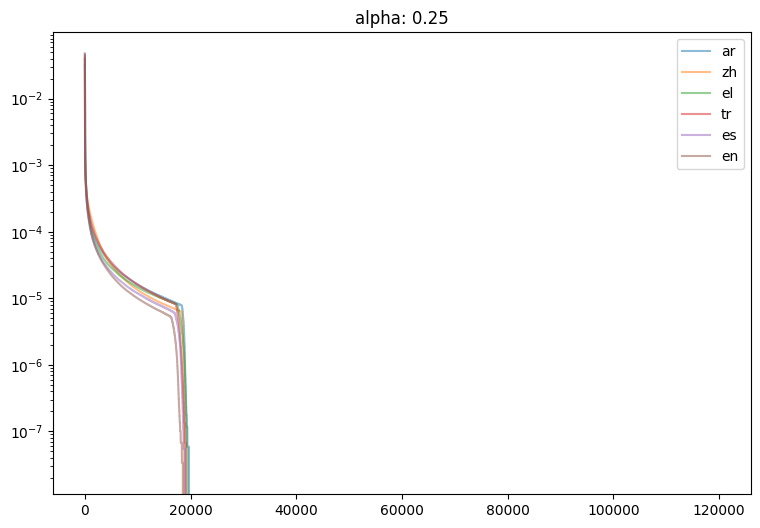

<Figure size 640x480 with 0 Axes>

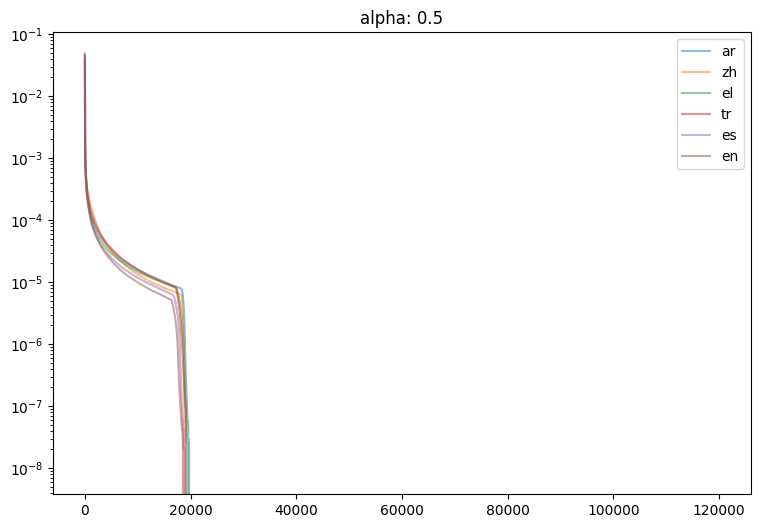

In [25]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    percentile_idx = {}
    for lang in languages:
        sorted_data = np.sort(token_dists[alpha][lang])[::-1]
        ax.plot(sorted_data, label=lang, alpha=0.5)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    ax.legend()
    plt.show()

        

<Figure size 640x480 with 0 Axes>

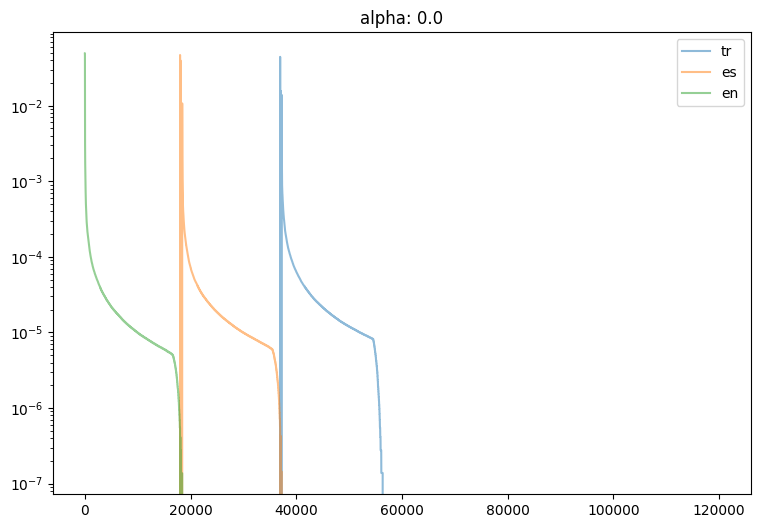

<Figure size 640x480 with 0 Axes>

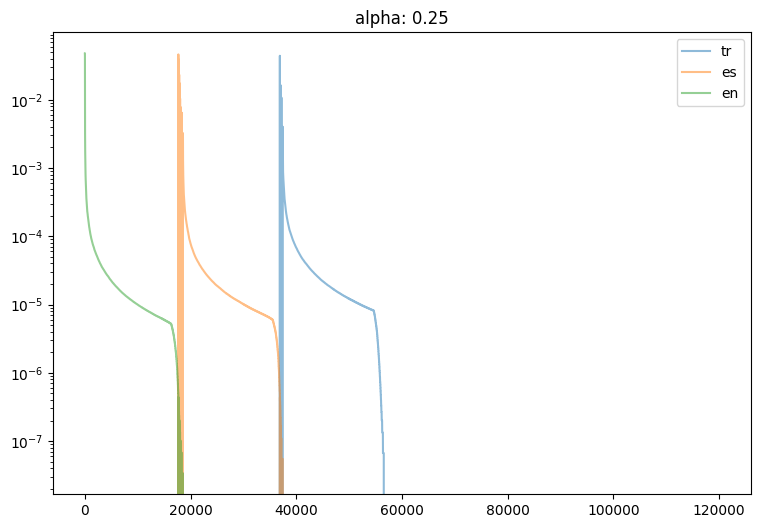

<Figure size 640x480 with 0 Axes>

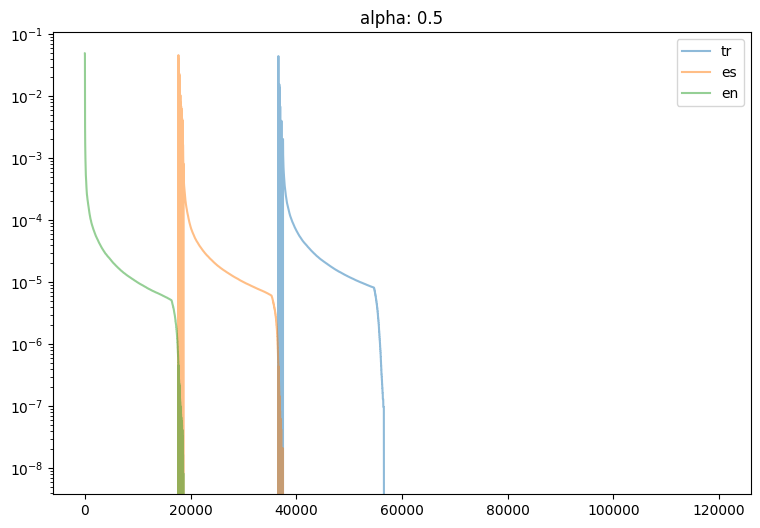

In [26]:
langugage_subset = ('tr','es', 'en')
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    index_sort_key = np.zeros_like(overall_token_dists[alpha])
    for lang_idx, lang in enumerate(langugage_subset):
        index_sort_key -= token_dists[alpha][lang] * pow(100000, lang_idx)
    index_sort = np.argsort(index_sort_key)
    for lang in langugage_subset:
        ax.plot(token_dists[alpha][lang][index_sort], label=lang, alpha=0.5)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    ax.legend()


# CDFs

<Figure size 640x480 with 0 Axes>

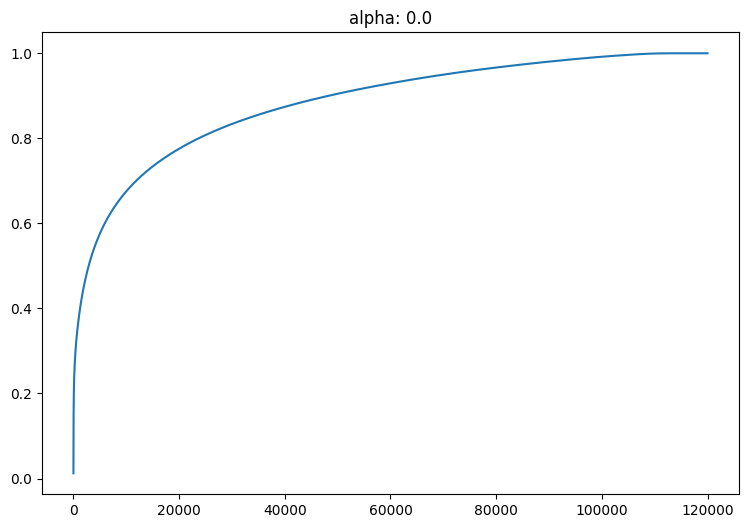

quatniles: 0.90, 0.95, 0.99, 0.999: [48261, 70124, 98140, 108863]
average rank: 14007


<Figure size 640x480 with 0 Axes>

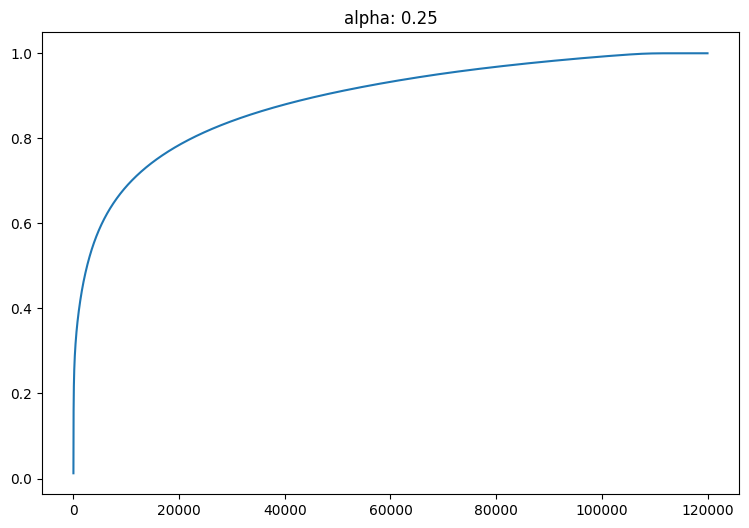

quatniles: 0.90, 0.95, 0.99, 0.999: [46617, 68699, 97737, 107898]
average rank: 13472


<Figure size 640x480 with 0 Axes>

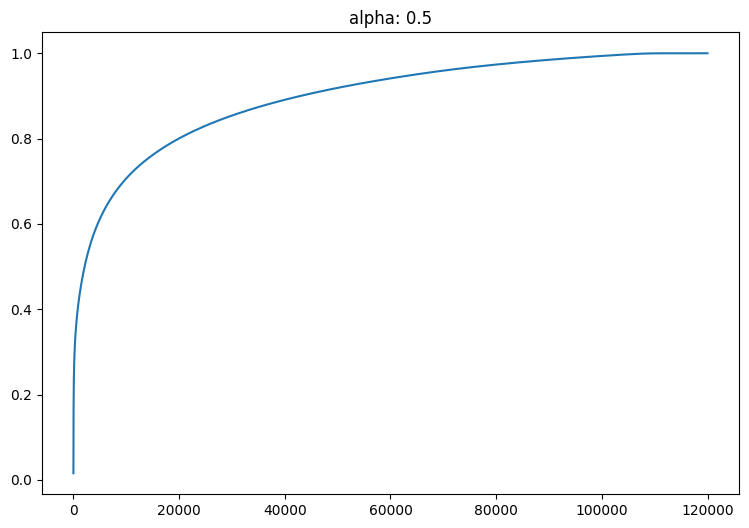

quatniles: 0.90, 0.95, 0.99, 0.999: [42965, 64597, 95544, 107308]
average rank: 12385


In [27]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    sorted_data = np.sort(overall_token_dists[alpha])[::-1]
    ax.plot(np.cumsum(sorted_data))

    ax.set_title(f"alpha: {alpha}")
    plt.show()



    percentile_idx = [ np.abs(np.cumsum(sorted_data) - perc).argmin() for perc in (0.9, 0.95, 0.99, 0.999)]
    avg_rang = np.sum(sorted_data * np.arange(len(sorted_data)))
    print(f"quatniles: 0.90, 0.95, 0.99, 0.999: {percentile_idx}")
    print(f"average rank: {np.round(avg_rang):.0f}")

<Figure size 640x480 with 0 Axes>

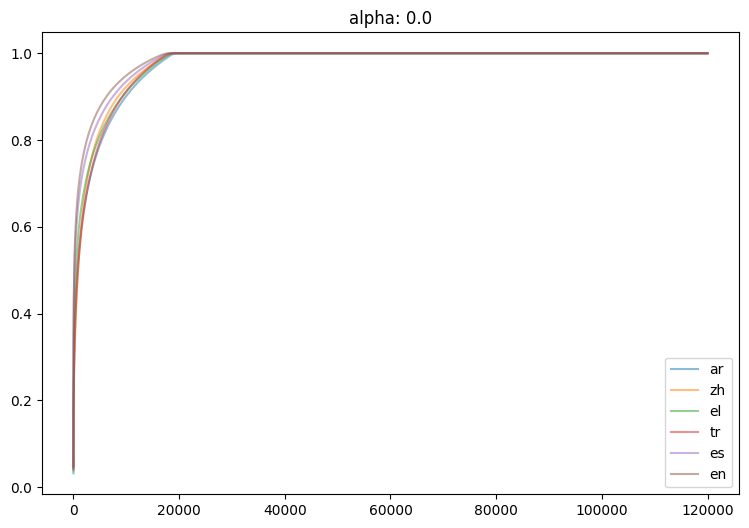

ar percentiles: 0.90, 0.95, 0.99, 0.999: [9908, 13610, 17732, 18935]
ar average rang: 2930
zh percentiles: 0.90, 0.95, 0.99, 0.999: [8456, 12302, 17015, 18379]
zh average rang: 2636
el percentiles: 0.90, 0.95, 0.99, 0.999: [9240, 13013, 17148, 18574]
el average rang: 2600
tr percentiles: 0.90, 0.95, 0.99, 0.999: [9273, 12758, 16717, 18043]
tr average rang: 2829
es percentiles: 0.90, 0.95, 0.99, 0.999: [7454, 11356, 16252, 17955]
es average rang: 2054
en percentiles: 0.90, 0.95, 0.99, 0.999: [6235, 10125, 15488, 17372]
en average rang: 1751


<Figure size 640x480 with 0 Axes>

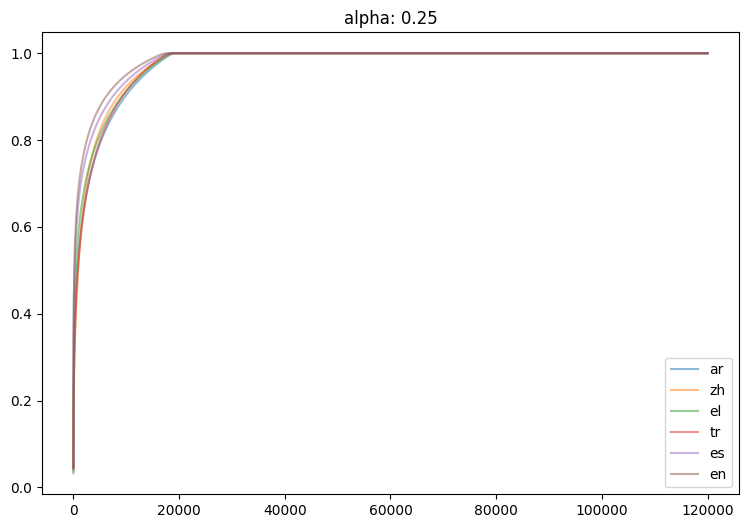

ar percentiles: 0.90, 0.95, 0.99, 0.999: [9753, 13391, 17456, 18639]
ar average rang: 2886
zh percentiles: 0.90, 0.95, 0.99, 0.999: [8425, 12274, 17017, 18393]
zh average rang: 2628
el percentiles: 0.90, 0.95, 0.99, 0.999: [9164, 12903, 17014, 18437]
el average rang: 2578
tr percentiles: 0.90, 0.95, 0.99, 0.999: [9218, 12671, 16630, 17951]
tr average rang: 2813
es percentiles: 0.90, 0.95, 0.99, 0.999: [7411, 11288, 16136, 17790]
es average rang: 2044
en percentiles: 0.90, 0.95, 0.99, 0.999: [6152, 9970, 15215, 17061]
en average rang: 1738


<Figure size 640x480 with 0 Axes>

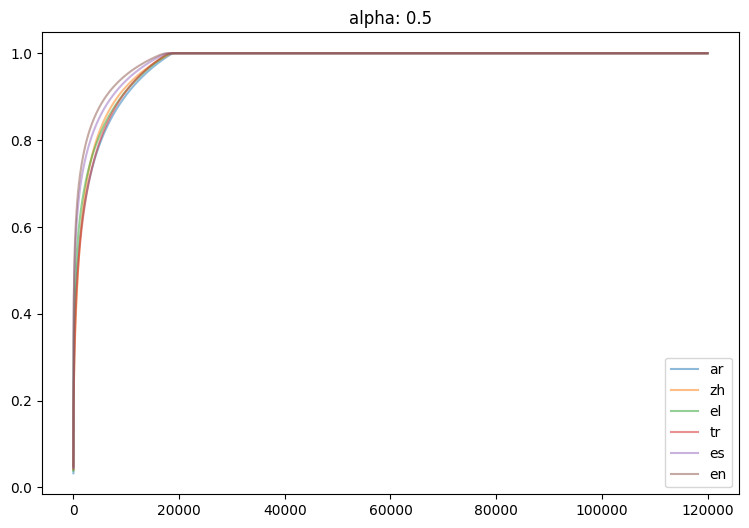

ar percentiles: 0.90, 0.95, 0.99, 0.999: [9742, 13378, 17451, 18630]
ar average rang: 2882
zh percentiles: 0.90, 0.95, 0.99, 0.999: [8404, 12259, 17017, 18397]
zh average rang: 2624
el percentiles: 0.90, 0.95, 0.99, 0.999: [9100, 12790, 16845, 18248]
el average rang: 2564
tr percentiles: 0.90, 0.95, 0.99, 0.999: [9195, 12666, 16646, 17978]
tr average rang: 2808
es percentiles: 0.90, 0.95, 0.99, 0.999: [7294, 11111, 15903, 17533]
es average rang: 2012
en percentiles: 0.90, 0.95, 0.99, 0.999: [6117, 9937, 15231, 17095]
en average rang: 1728


In [28]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    percentile_idx = {}
    avg_rangs = {}
    for lang in languages:
        sorted_data = np.sort(token_dists[alpha][lang])[::-1]
        ax.plot(np.cumsum(sorted_data), label=lang, alpha=0.5)
        percentile_idx[lang] = [ np.abs(np.cumsum(sorted_data) - perc).argmin() for perc in (0.9, 0.95, 0.99, 0.999)]
        avg_rangs[lang] = np.sum(sorted_data * np.arange(len(sorted_data)))
    ax.set_title(f"alpha: {alpha}")
    ax.legend()
    plt.show()
    for lang in languages:
        print(f"{lang} percentiles: 0.90, 0.95, 0.99, 0.999: {percentile_idx[lang]}")
        print(f"{lang} average rang: {np.round(avg_rangs[lang]):.0f}")
        